In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mplPath
import numpy as np
import cv2

last_slope_left = 1
last_slope_right = 1

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


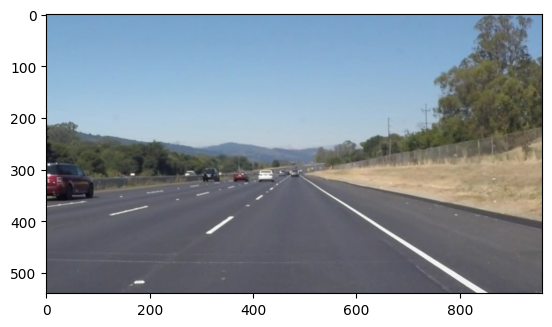

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

In [4]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):    
    leftLane = [0, 0, 0, 0, 0]
    rightLane = [0, 0, 0, 0, 0]
    
    vertices = np.array([[100,540],[420, 330], [520, 330], [900,540]])
    bbPath = mplPath.Path(vertices)
    
    minX = 100
    maxX = 900
    
    minY = 330
    maxY = 540
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (bbPath.contains_point([x1, y1]) is not True):
                continue
            m = (y2 - y1) / (x2 - x1)
            #b = y - mx
            b = y1 - (m * x1)
            if (m > 0):
                rightLane[0] = rightLane[0] + m
                rightLane[1] += 1
                rightLane[2] += b
                rightLane[3] = x1
                rightLane[4] = y1
            else:
                leftLane[0] = leftLane[0] + m
                leftLane[1] += 1
                leftLane[2] += b
                leftLane[3] = x1
                leftLane[4] = y1
    
    left_lane_slope = 0
    left_lane_y_intercept = 0
    right_lane_slope = 0
    right_lane_y_intercept = 0
    
    global last_slope_left
    global last_slope_right
    
    if (leftLane[1] != 0):
        left_lane_slope = leftLane[0] / leftLane[1]
        left_lane_y_intercept = leftLane[2] / leftLane[1]
        last_slope_left = left_lane_slope
    else:
        left_lane_slope = last_slope_left
    
    if (rightLane[1] != 0):
        right_lane_slope = rightLane[0] / rightLane[1]
        right_lane_y_intercept = rightLane[2] / rightLane[1]
        last_slope_right = right_lane_slope
    else:
        right_lane_slope = last_slope_right
    
    
    x_bottom_left_lane = (maxY - left_lane_y_intercept) / left_lane_slope
    y_bottom_left_lane = left_lane_slope * x_bottom_left_lane + left_lane_y_intercept

    
    x_top_left_lane = (minY - left_lane_y_intercept) / left_lane_slope
    y_top_left_lane = left_lane_slope * x_top_left_lane + left_lane_y_intercept
    
    cv2.line(img, (int(round(x_bottom_left_lane)), int(round(y_bottom_left_lane))), (int(round(x_top_left_lane)), int(round(y_top_left_lane))), [255, 0, 0], thickness)
    
    
    minX_right = 100
    maxX_right = 900
    
    minY_right = 330
    maxY_right = 540
    
    x_bottom_right_lane = (maxY_right - right_lane_y_intercept) / right_lane_slope
    y_bottom_right_lane = right_lane_slope * x_bottom_right_lane + right_lane_y_intercept
    
    x_top_right_lane = (minY - right_lane_y_intercept) / right_lane_slope
    y_top_right_lane = right_lane_slope * x_top_right_lane + right_lane_y_intercept
    
    cv2.line(img, (int(round(x_bottom_right_lane)), int(round(y_bottom_right_lane))), (int(round(x_top_right_lane)), int(round(y_top_right_lane))), [0, 255, 0], thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, [0, 255, 0], 15)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

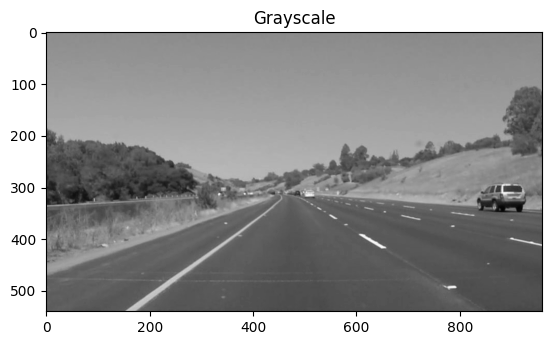

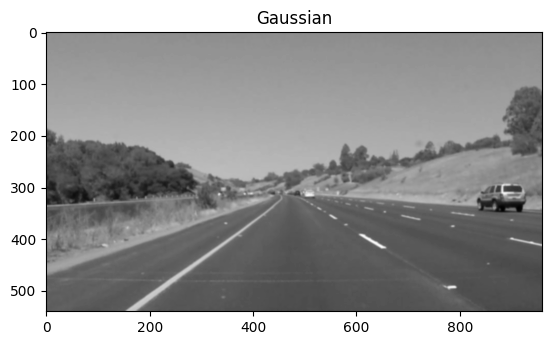

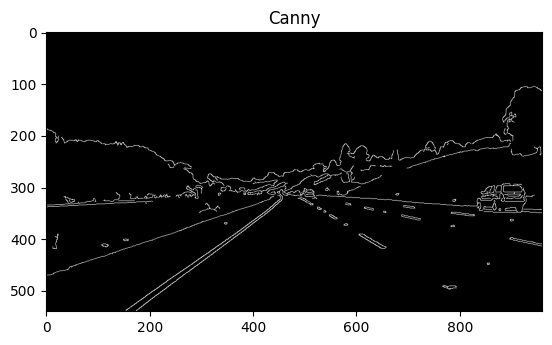

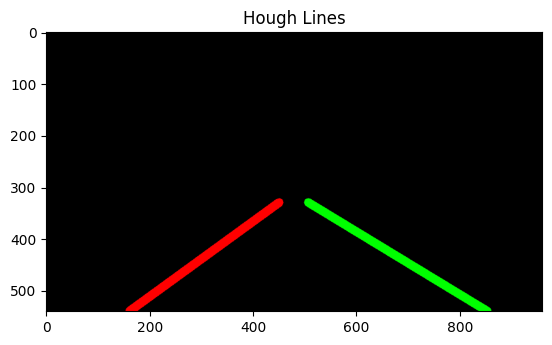

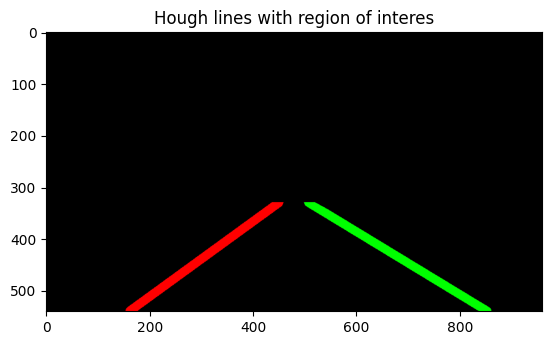

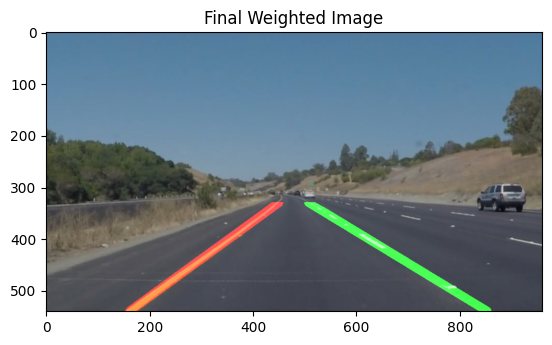

In [5]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')

gray_img = grayscale(image)

gaussian_img = gaussian_blur(gray_img, 5)
canny_img = canny(gaussian_img, 50, 150)

rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30 #minimum number of pixels making up a line
max_line_gap = 3    # maximum gap in pixels between connectable line segments

hough_img = hough_lines(canny_img, rho, theta, threshold, min_line_length, max_line_gap)

imshape = hough_img.shape
vertices = np.array([[(100,imshape[0]),(420, 330), (520, 330), (imshape[1]-60,imshape[0])]], dtype=np.int32)

reg_interest_img = region_of_interest(hough_img, vertices)

final_image = weighted_img(reg_interest_img, image)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale")
plt.show()

plt.imshow(gaussian_img, cmap='gray')
plt.title("Gaussian")
plt.show()

plt.imshow(canny_img, cmap='gray')
plt.title("Canny")
plt.show()

plt.imshow(hough_img, cmap='gray')
plt.title("Hough Lines")
plt.show()

plt.imshow(reg_interest_img, cmap='gray')
plt.title("Hough lines with region of interes")
plt.show()

plt.imshow(final_image, cmap='gray')
plt.title("Final Weighted Image")
plt.show()

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    gray_img = grayscale(image)

    gaussian_img = gaussian_blur(gray_img, 5)

    canny_img = canny(gaussian_img, 50, 150)

    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments

    hough_img = hough_lines(canny_img, rho, theta, threshold, min_line_length, max_line_gap)

    imshape = hough_img.shape
    vertices = np.array([[(100,imshape[0]),(420, 330), (520, 330), (imshape[1]-60,imshape[0])]], dtype=np.int32)

    reg_interest_img = region_of_interest(hough_img, vertices)

    final_image = weighted_img(reg_interest_img, image)

    return final_image

Test 1

In [8]:
output = './test_videos_output/test_output.mp4'

clip1 = VideoFileClip("./test_videos/test.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

Moviepy - Building video ./test_videos_output/test_output.mp4.
Moviepy - Writing video ./test_videos_output/test_output.mp4



Moviepy - Done !
Moviepy - video ready ./test_videos_output/test_output.mp4
CPU times: total: 1.03 s
Wall time: 3.22 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Final Test

In [10]:
output_2 = './test_videos_output/final_test_output.mp4'

clip1 = VideoFileClip("./test_videos/final_test.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output_2, audio=False)

Moviepy - Building video ./test_videos_output/final_test_output.mp4.
Moviepy - Writing video ./test_videos_output/final_test_output.mp4



Moviepy - Done !
Moviepy - video ready ./test_videos_output/final_test_output.mp4
CPU times: total: 4 s
Wall time: 9.5 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_2))